[*********************100%***********************]  5 of 5 completed


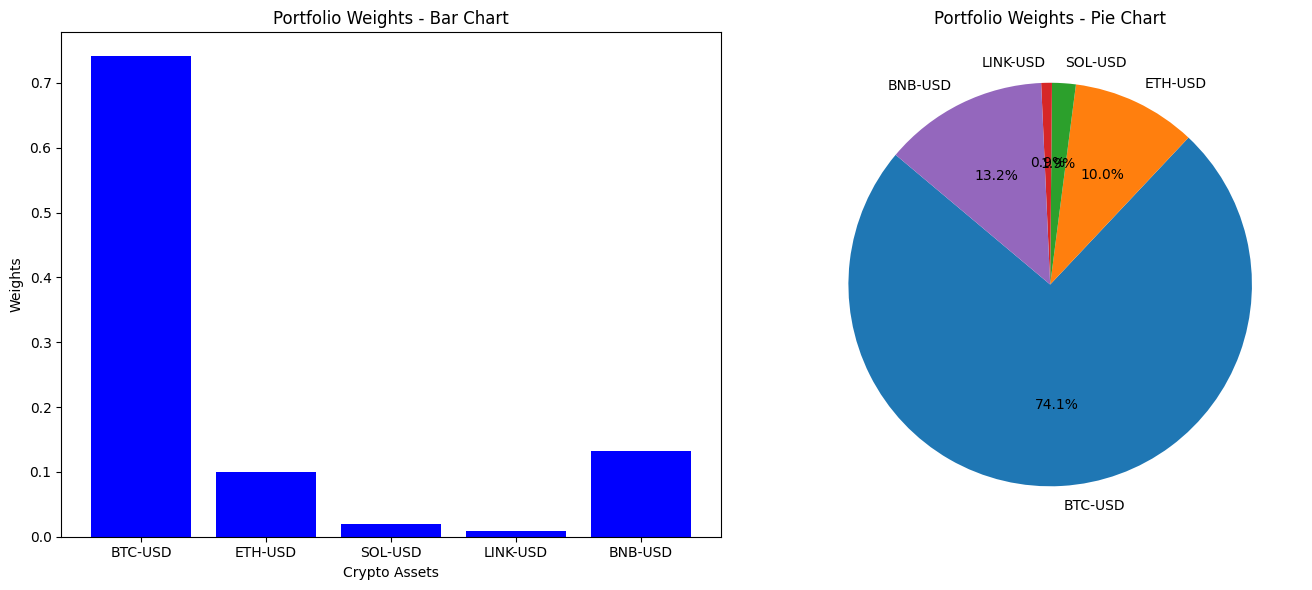

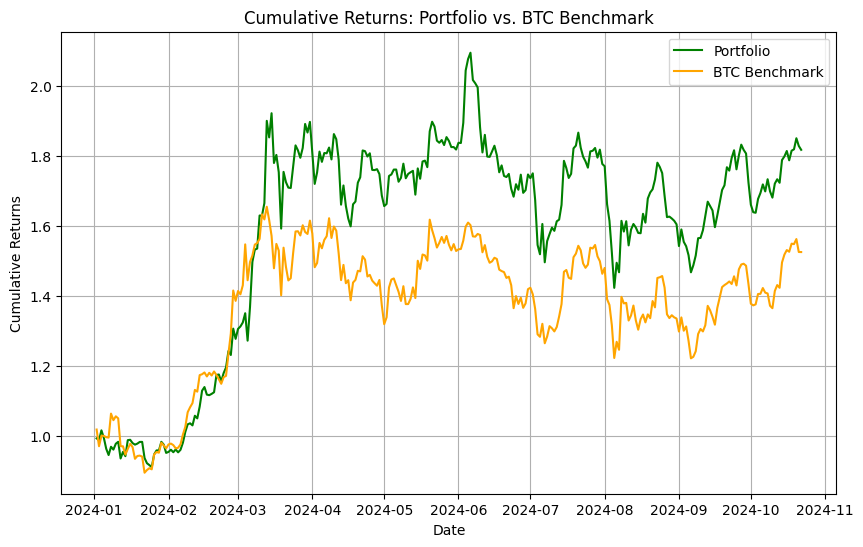

Cumulative Return: 81.73%
Volatility (Annualized): 46.34%
Sharpe Ratio: 1.31
Sortino Ratio: 0.01
Maximum Drawdown: -32.08%


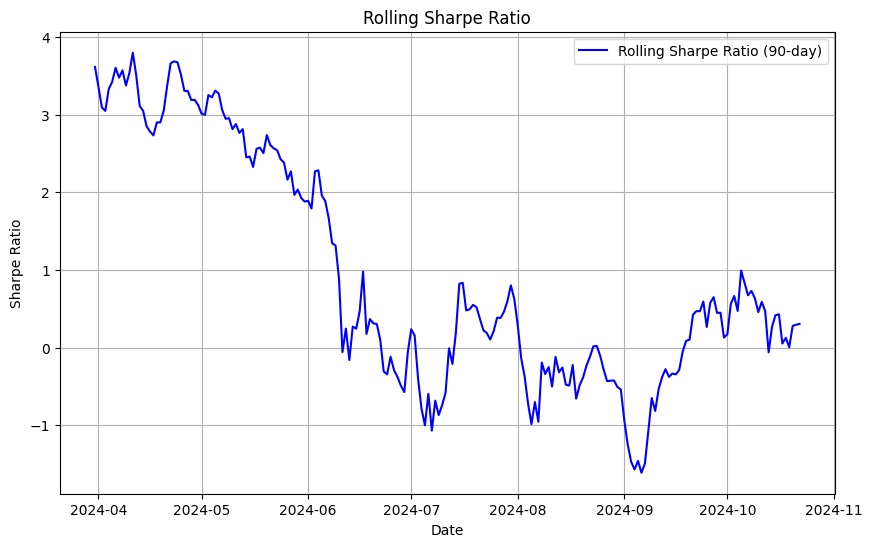

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

# Step 1: Fetching data from yfinance for a portfolio of 5 Crypto assets (BTC, ETH, SOL, LINK, BNB)
cryptos = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'LINK-USD', 'BNB-USD']
start_date = '2024-01-01'
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

# Download the data
data = yf.download(cryptos, start=start_date, end=end_date)['Adj Close']

# Step 2: Calculate daily simple returns
simple_returns = data.pct_change().dropna()

# Step 3: Implement Genetic Algorithm to find optimal portfolio weights
# GA Parameters
population_size = 50
num_generations = 200
mutation_rate = 0.3
epsilon = 1e-5  # Tolerance for weight sum check

# Fitness function to evaluate portfolio return
def fitness_function(weights, simple_returns):
    if any(weights < 0) or abs(sum(weights) - 1) > epsilon:
        return -np.inf  # Penalize invalid weights
    portfolio_return = simple_returns.dot(weights)
    return portfolio_return.mean() / portfolio_return.std()  # Sharpe Ratio

# Initialize population with random weights
population = [np.random.dirichlet(np.ones(len(cryptos)), size=1)[0] for _ in range(population_size)]

# Genetic Algorithm
for generation in range(num_generations):
    # Evaluate fitness of each individual
    fitness_scores = [fitness_function(individual, simple_returns) for individual in population]

    # Select parents based on fitness
    parents = [population[i] for i in np.argsort(fitness_scores)[-population_size//2:]]

    # Crossover - Create offspring by averaging pairs of parents
    offspring = []
    for _ in range(population_size - len(parents)):
        parent1, parent2 = random.sample(parents, 2)
        child = (parent1 + parent2) / 2
        child = np.clip(child, 0, 1)  # Ensure weights are non-negative
        child /= sum(child)  # Normalize to sum to 1
        offspring.append(child)

    # Mutation - Randomly alter some weights
    for individual in offspring:
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(cryptos) - 1)
            individual[mutation_index] += np.random.normal(0, 0.1)
            individual = np.clip(individual, 0, 1)  # Ensure weights are between 0 and 1
            individual /= sum(individual)  # Normalize to sum to 1

    # Set new population
    population = parents + offspring

# Select the best individual as the optimal weights
fitness_scores = [fitness_function(individual, simple_returns) for individual in population]
optimal_weights = population[np.argmax(fitness_scores)]

# Step 4: Portfolio weights and structure
weights = optimal_weights  # Assign GA-optimized weights to the cryptos
portfolio_returns = simple_returns.dot(weights)  # Daily portfolio returns

# Visualization of the portfolio structure
plt.figure(figsize=(14, 6))

# Bar chart
plt.subplot(1, 2, 1)
plt.bar(cryptos, weights, color='blue')
plt.xlabel('Crypto Assets')
plt.ylabel('Weights')
plt.title('Portfolio Weights - Bar Chart')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(weights, labels=cryptos, autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Weights - Pie Chart')

plt.tight_layout()
plt.show()

# Step 5: Calculate cumulative returns for portfolio and benchmark (BTC)
portfolio_cum_returns = (1 + portfolio_returns).cumprod()
btc_cum_returns = (1 + simple_returns['BTC-USD']).cumprod()

# Combine cumulative returns into a single DataFrame
cumulative_returns = pd.DataFrame({'Portfolio': portfolio_cum_returns, 'BTC Benchmark': btc_cum_returns})

# Step 6: Plot cumulative returns of portfolio vs. BTC benchmark
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index, cumulative_returns['Portfolio'], label='Portfolio', color='green')
plt.plot(cumulative_returns.index, cumulative_returns['BTC Benchmark'], label='BTC Benchmark', color='orange')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns: Portfolio vs. BTC Benchmark')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Calculate Sharpe, Sortino ratios, and Maximum Drawdown for the portfolio
risk_free_rate = 0.01 / 252  # Assuming a 1% annual risk-free rate, converted to daily

# Sharpe Ratio
excess_returns = portfolio_returns - risk_free_rate
sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# Sortino Ratio
target_return = 0  # Target return can also be set to risk-free rate
downside_returns = portfolio_returns[portfolio_returns < target_return]
downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(252)
sortino_ratio = excess_returns.mean() / downside_deviation

# Maximum Drawdown
rolling_max = portfolio_cum_returns.cummax()
drawdown = (portfolio_cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Step 8: Display summary statistics
cumulative_return_value = portfolio_cum_returns.iloc[-1] - 1
volatility = portfolio_returns.std() * np.sqrt(252)

print(f"Cumulative Return: {cumulative_return_value:.2%}")
print(f"Volatility (Annualized): {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Step 9: Rolling Sharpe Ratio
rolling_sharpe = excess_returns.rolling(window=90).mean() / excess_returns.rolling(window=90).std() * np.sqrt(252)
plt.figure(figsize=(10, 6))
plt.plot(rolling_sharpe, label='Rolling Sharpe Ratio (90-day)', color='blue')
plt.title('Rolling Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()
